# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras.python.keras.utils.io_utils import HDF5Matrix
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Activation
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

Import data as HDF5 Matrix

In [3]:
img_train = HDF5Matrix('/data/joint_scoring/img_train.h5', 'img_train')
img_test = HDF5Matrix('/data/joint_scoring/img_test.h5', 'img_test')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_onehot.h5', 'labels_train_onehot')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_onehot.h5', 'labels_test_onehot')

In [4]:
num_classes = 6

## 2. Model

In [5]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=num_classes, activation="softmax",
                    kernel_initializer="he_normal"))

    # Compile model
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [6]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [7]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [8]:
print(new_folder)

20171028_125339


In [9]:
desc = "Model with on original data"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [10]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [ ]:
# Fit the model
model.fit(x=img_train, y=labels_train, batch_size=100, epochs=25, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test, labels_test),
          shuffle="batch")

Train on 72298 samples, validate on 19611 samples
Epoch 1/25
72298/72298 [==============================] - 183s - loss: 0.8653 - acc: 0.6572 - val_loss: 0.7528 - val_acc: 0.6901
Epoch 2/25
72298/72298 [==============================] - 182s - loss: 0.7047 - acc: 0.7007 - val_loss: 0.9905 - val_acc: 0.6863
Epoch 3/25
72298/72298 [==============================] - 182s - loss: 0.6548 - acc: 0.7216 - val_loss: 0.6367 - val_acc: 0.7347
Epoch 4/25
72298/72298 [==============================] - 182s - loss: 0.6245 - acc: 0.7370 - val_loss: 0.6921 - val_acc: 0.7273
Epoch 5/25
72298/72298 [==============================] - 182s - loss: 0.6008 - acc: 0.7469 - val_loss: 0.6003 - val_acc: 0.7467
Epoch 6/25
72298/72298 [==============================] - 182s - loss: 0.5814 - acc: 0.7547 - val_loss: 0.7014 - val_acc: 0.7322
Epoch 7/25
72298/72298 [==============================] - 182s - loss: 0.5415 - acc: 0.7729 - val_loss: 0.7703 - val_acc: 0.7316
Epoch 9/25
72298/72298 [=======================

In [12]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print("Error: %.2f%%" % (100 - scores[1] * 100))

Error: 27.67%


In [13]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict_classes(img_test)
p = model.predict_proba(img_test)

print(classification_report(np.argmax(labels_test, axis=1), pred))
cnf_matrix = confusion_matrix(np.argmax(labels_test, axis=1), pred)
print(cnf_matrix)

19611/19611 [==============================] - 14s    
             precision    recall  f1-score   support

          0       0.75      0.97      0.84     13286
          1       0.60      0.23      0.33      5369
          2       0.26      0.09      0.14       423
          3       0.18      0.18      0.18       177
          4       0.20      0.02      0.04        98
          5       0.52      0.20      0.29       258

avg / total       0.69      0.72      0.67     19611

[[12845   424     5     5     0     7]
 [ 4077  1215    48    20     0     9]
 [  130   213    40    32     0     8]
 [   33    78    26    32     0     8]
 [   15    30    10    26     2    15]
 [   55    62    24    58     8    51]]


Confusion matrix, without normalization
[[12845   424     5     5     0     7]
 [ 4077  1215    48    20     0     9]
 [  130   213    40    32     0     8]
 [   33    78    26    32     0     8]
 [   15    30    10    26     2    15]
 [   55    62    24    58     8    51]]
Normalized confusion matrix
[[  9.66807165e-01   3.19132922e-02   3.76335993e-04   3.76335993e-04
    0.00000000e+00   5.26870390e-04]
 [  7.59359285e-01   2.26299125e-01   8.94021233e-03   3.72508847e-03
    0.00000000e+00   1.67628981e-03]
 [  3.07328605e-01   5.03546099e-01   9.45626478e-02   7.56501182e-02
    0.00000000e+00   1.89125296e-02]
 [  1.86440678e-01   4.40677966e-01   1.46892655e-01   1.80790960e-01
    0.00000000e+00   4.51977401e-02]
 [  1.53061224e-01   3.06122449e-01   1.02040816e-01   2.65306122e-01
    2.04081633e-02   1.53061224e-01]
 [  2.13178295e-01   2.40310078e-01   9.30232558e-02   2.24806202e-01
    3.10077519e-02   1.97674419e-01]]


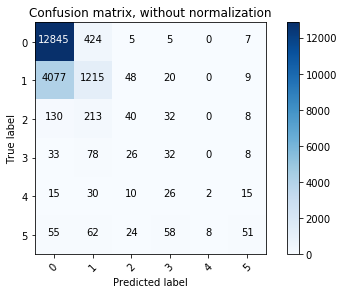

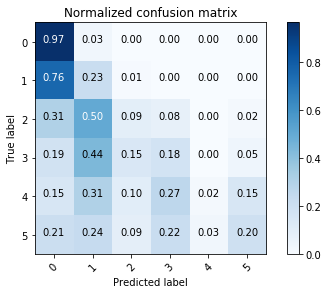

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [19]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_classification_original.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)